In [16]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import math
import os
from scipy.interpolate import interp2d
from scipy import ndimage, misc

In [17]:
def tand(x):
    return math.tan(x * math.pi / 180)

def sind(x):
    return math.sin(x * math.pi / 180)

def cosd(x):
    return math.cos(x * math.pi / 180)

In [18]:
def converting(img,PA=0,inclination=0,final_radius=100,pw=360,r0=40,times=2,center=None,shcamp='flag'):    
    theta_ , R_ = np.meshgrid(np.linspace(0, 2*np.pi, pw), 
                            np.arange(0, final_radius))
    if center==None:
        if len(img)/2 ==0:
            c=len(img)/2-0.5
        else:
            c=(len(img)-1)/2
        center=[c,c]
    
    x=np.linspace(0, len(img)-1,len(img), dtype=int)
    y=np.linspace(0, len(img)-1,len(img), dtype=int)
    f=interp2d(x,y,img,kind='cubic')
    z2=[[[]for i in range(pw)]for i in range(final_radius)]
    theta=0
    while theta<90:
        r=1
        while r<final_radius:
            rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
            x=rr*cosd(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+PA)+center[0]
            y=rr*sind(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+PA)+center[1]
            z2[r][theta]=float(f(x,y))*((rr/r0)**times)

            r+=1
        theta+=1
    theta=90
    r=1
    while r<final_radius:
        rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
        x=(r*(cosd(inclination))*cosd(90+PA))+center[0]
        y=(r*(cosd(inclination))*sind(90+PA))+center[1]
        z2[r][theta]=float(f(x,y))*((rr/r0)**times)
        r+=1


    theta=91
    while theta<=180:
        r=1
        while r<final_radius:
            rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
            x=rr*cosd(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+180+PA)+center[0]
            y=rr*sind(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+180+PA)+center[1]
            z2[r][theta]=float(f(x,y))*((rr/r0)**times)

            r+=1
        theta+=1

    while theta<270:
        r=1

        while r<final_radius:
            rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
            x=rr*cosd(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+180+PA)+center[0]
            y=rr*sind(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+180+PA)+center[1]
            z2[r][theta]=float(f(x,y))*((rr/r0)**times)

            r+=1
        theta+=1

    theta=270
    r=1
    while r<final_radius:
        rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
        x=-(r*(cosd(inclination))*cosd(90+PA))+center[0]
        y=-(r*(cosd(inclination))*sind(90+PA))+center[1]
        z2[r][theta]=float(f(x,y))*((rr/r0)**times)
        r+=1
    theta=271
    while theta<360:
        r=1
        while r<final_radius:
            rr=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)
            x=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)*cosd(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+PA)+center[0]
            y=(r*((sind(theta)*cosd(inclination))**2+(cosd(theta))**2)**0.5)*sind(np.arctan(tand(theta)*cosd(inclination))*180/math.pi+PA)+center[1]
            z2[r][theta]=float(f(x,y))*((rr/r0)**times)
            r+=1
        theta+=1


    r=0
    theta=0
    while theta<360:
        z2[r][theta]=float(f(center[0],center[1]))
        theta+=1
    plt.imshow(z2, cmap= shcamp,origin='lower')
    return z2

In [19]:
def gs(x,A1,sigma1,miu1,A0):#gaussian distribution function
    return A1*(1/((2**0.5)*sigma1))*math.e**((-(x-miu1)**2)/(2*sigma1**2))+A0

In [20]:
def fit_for_center(img_p,x_init,x_fin,y_init,y_fin,width=10,
                   theta=None,rad=None,prob=None):
    if (theta==None) & (rad==None) & (prob==None):
        theta=[]
        rad=[]
        prob=[]
    elif (theta==None) or (rad==None) or (prob==None):
        raise ValueError('please input theta, radius and probability together')
    w=width
    j=x_init
    while (j <=x_fin):
        X1=[]
        Y1=[]
        i=y_init
        max1=0
        a=0
        while i < y_fin:
            if img_p[i][j]>=0:
                y=img_p[i][j]
                X1.append(i)
                Y1.append(y)
                if img_p[i][j]>max1:
                    max1=img_p[i][j]
                    a=i          #a is the location of the maximum 
            i+=1
        xdata=X1
        ydata=Y1
        b=img_p[a][j]
        c=w/2          
        d1=int(min(X1))             
        cen=Y1.index(max(Y1))
        w=width
        popt, pcov = curve_fit(gs,xdata[cen-w:cen+w],ydata[cen-w:cen+w],[b-d1,c,a,d1],maxfev=5000000)

        if (popt[2] < max(X1))&(popt[2] > min(X1)):
            rad.append(popt[2])
            theta.append(j)
            p=np.sqrt(pcov[2][2])
            prob.append(p)
        j+=1 
    return theta, rad, prob
    

In [21]:
def f_withRn(X,rp,n,a0,a1,a2,a3,a4,a5):
    z,y,k=X
    x=z+y*rp*(k/60)**n
    return a0+a1*x**1+a2*(x)**2+a3*(x)**3+a4*x**4+a5*x**5

def f_withoutRn(X,rp,a0,a1,a2,a3,a4,a5):
    z,y=X
    x=z+y*rp
    return a0+a1*x**1+a2*(x)**2+a3*(x)**3+a4*x**4+a5*x**5

In [22]:
def fitting(theta1,theta2,rad1,rad2,prob1,prob2,est=-0.1,withRn=True):
    
    theta=np.hstack((theta1,theta2))
    theta1b=np.zeros(len(theta1))
    theta2b=np.ones(len(theta2))
    
    thetab=np.hstack((theta1b,theta2b))
    rad=np.hstack((rad1,rad2))
    P=np.hstack((prob1,prob2))

    if withRn==True:
        thetaf=np.vstack((theta,thetab,rad))
        popt, pcov = curve_fit(f_withRn,thetaf,rad,[est]*8,sigma=P,absolute_sigma=True,maxfev=5000000)

    else:
        thetaf=np.vstack((theta,thetab))
        popt, pcov = curve_fit(f_withoutRn,thetaf,rad,[est]*7,sigma=P,absolute_sigma=True,maxfev=5000000)
    
    return popt, pcov


In [23]:
xaa=fits.open('x1a.fits')
xbb=fits.open('x1b.fits')

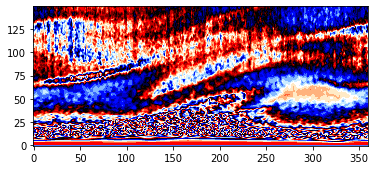

In [24]:
xa=xaa[0].data
xb=xbb[0].data
poa=converting(xa,-50,0,150,360,40,2)
pob=converting(xb,-50,0,150,360,40,2)

In [43]:
Z1,K1,P1=fit_for_center(poa,0,70,50,85,width=10,
                   theta=None,rad=None,prob=None)
Z1,K1,P1=fit_for_center(poa,71,100,50,95,width=10,
                   theta=Z1,rad=K1,prob=P1)
Z2,K2,P2=fit_for_center(pob,0,70,50,85,width=10,
                   theta=None,rad=None,prob=None)
Z2,K2,P2=fit_for_center(pob,71,100,50,100,width=10,
                   theta=Z2,rad=K2,prob=P2)


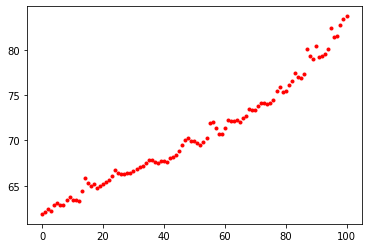

In [44]:
plt.plot(Z1, K1, 'r.')

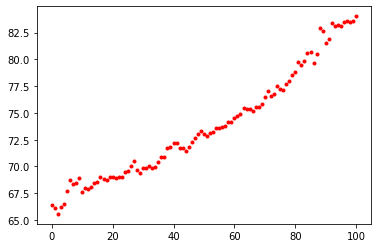

In [45]:
plt.plot(Z2, K2, 'r.')

In [46]:
popt, pcov=fitting(Z1,Z2,K1,K2,P1,P2,est=-5,withRn=True)

In [47]:
print(popt)
print(pcov)

[ 5.59456664e+01 -6.33827478e+00  6.20412603e+01  1.56318953e-01
  1.05362905e-03 -4.85580860e-05  6.72953873e-07 -2.47653715e-09]
[[ 3.90837063e+00 -3.74993240e-01 -1.16068588e-02  5.24770386e-03
  -4.14023080e-04  1.03540082e-05 -1.04142541e-07  3.78811191e-10]
 [-3.74993240e-01  3.91674864e-02  1.10369139e-03 -4.95434801e-04
   3.94687686e-05 -1.01355469e-06  1.04005031e-08 -3.84560484e-11]
 [-1.16068588e-02  1.10369139e-03  1.15699525e-02 -1.81762510e-03
   8.88918063e-05 -1.86091962e-06  1.74515180e-08 -6.02597972e-11]
 [ 5.24770386e-03 -4.95434801e-04 -1.81762510e-03  4.20143303e-04
  -2.36700841e-05  5.33657347e-07 -5.23793441e-09  1.86550559e-11]
 [-4.14023080e-04  3.94687686e-05  8.88918063e-05 -2.36700841e-05
   1.41553276e-06 -3.30870588e-08  3.32857188e-10 -1.20716545e-12]
 [ 1.03540082e-05 -1.01355469e-06 -1.86091962e-06  5.33657347e-07
  -3.30870588e-08  7.92459527e-10 -8.11579423e-12  2.98398844e-14]
 [-1.04142541e-07  1.04005031e-08  1.74515180e-08 -5.23793441e-09
   3.